In [1]:
import numpy as np
import argparse
import os
import sys
import random
sys.path.append(os.getcwd())
import torch
from data.dataloader_nba import NBADataset, seq_collate
from model.GroupNet_nba import GroupNet
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.lines as mlines

class Constant:
	"""A class for handling constants"""
	NORMALIZATION_COEF = 7
	PLAYER_CIRCLE_SIZE = 12 / NORMALIZATION_COEF
	INTERVAL = 10
	DIFF = 6
	X_MIN = 0
	X_MAX = 100
	Y_MIN = 0
	Y_MAX = 50
	COL_WIDTH = 0.3
	SCALE = 1.65
	FONTSIZE = 6
	X_CENTER = X_MAX / 2 - DIFF / 1.5 + 0.10
	Y_CENTER = Y_MAX - DIFF / 1.5 - 0.35
	MESSAGE = 'You can rerun the script and choose any event from 0 to '

def draw_result(future,past,mode='pre'):
	# b n t 2
	print('drawing...')
	trajs = np.concatenate((past,future), axis = 2)
	batch = trajs.shape[0]
	print('batch:',batch)

	if not os.path.isdir("vis/nba/"):
		os.makedirs("vis/nba/")

	for idx in range(2):
		plt.clf()
		traj = trajs[idx]
		traj = traj*94/28
		actor_num = traj.shape[0]
		length = traj.shape[1]
		
		ax = plt.axes(xlim=(Constant.X_MIN,
							Constant.X_MAX),
						ylim=(Constant.Y_MIN,
							Constant.Y_MAX))
		ax.axis('off')
		fig = plt.gcf()
		ax.grid(False)  # Remove grid

		colorteam1 = 'dodgerblue'
		colorteam2 = 'orangered'
		colorball = 'limegreen'
		colorteam1_pre = 'skyblue'
		colorteam2_pre = 'lightsalmon'
		colorball_pre = 'mediumspringgreen'
		
		for j in range(actor_num):
			if j < 5:
				color = colorteam1
				color_pre = colorteam1_pre
			elif j < 10:
				color = colorteam2
				color_pre = colorteam2_pre
			else:
				color_pre = colorball_pre
				color = colorball
			for i in range(length):
				points = [(traj[j,i,0],traj[j,i,1])]
				(x, y) = zip(*points)
				# plt.scatter(x, y, color=color,s=20,alpha=0.3+i*((1-0.3)/length))
				if i < 5:
					plt.scatter(x, y, color=color_pre,s=20,alpha=1)
				else:
					plt.scatter(x, y, color=color,s=20,alpha=1)

			for i in range(length-1):
				points = [(traj[j,i,0],traj[j,i,1]),(traj[j,i+1,0],traj[j,i+1,1])]
				(x, y) = zip(*points)
				# plt.plot(x, y, color=color,alpha=0.3+i*((1-0.3)/length),linewidth=2)
				if i < 4:
					plt.plot(x, y, color=color_pre,alpha=0.5,linewidth=2)
				else:
					plt.plot(x, y, color=color,alpha=1,linewidth=2)

		court = plt.imread("datasets/nba/court.png")
		plt.imshow(court, zorder=0, extent=[Constant.X_MIN, Constant.X_MAX - Constant.DIFF,
											Constant.Y_MAX, Constant.Y_MIN],alpha=0.5)
		if mode == 'pre':
			plt.savefig('vis/nba/'+str(idx)+'pre.png')
		else:
			plt.savefig('vis/nba/'+str(idx)+'gt.png')
	print('ok')
	return 

def test_model_all(test_loader, args):
	total_num_pred = 0
	all_num = 0
	l2error_overall = 0
	l2error_dest = 0
	l2error_avg_04s = 0
	l2error_dest_04s = 0
	l2error_avg_08s = 0
	l2error_dest_08s = 0
	l2error_avg_12s = 0
	l2error_dest_12s = 0
	l2error_avg_16s = 0
	l2error_dest_16s = 0
	l2error_avg_20s = 0
	l2error_dest_20s = 0
	l2error_avg_24s = 0
	l2error_dest_24s = 0
	l2error_avg_28s = 0
	l2error_dest_28s = 0
	l2error_avg_32s = 0
	l2error_dest_32s = 0
	l2error_avg_36s = 0
	l2error_dest_36s = 0

	for data in test_loader:
		future_traj = np.array(data['future_traj']) * args.traj_scale # B,N,T,2
		with torch.no_grad():
			prediction = model.inference(data)
		prediction = prediction * args.traj_scale
		prediction = np.array(prediction.cpu()) #(BN,20,T,2)
		batch = future_traj.shape[0]
		actor_num = future_traj.shape[1]

		y = np.reshape(future_traj,(batch*actor_num,args.future_length, 2))
		y = y[None].repeat(20,axis=0)
		l2error_avg_04s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:1,:] - prediction[:,:,:1,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_04s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,0:1,:] - prediction[:,:,0:1,:], axis = 3),axis=2),axis=0))*batch
		l2error_avg_08s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:2,:] - prediction[:,:,:2,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_08s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,1:2,:] - prediction[:,:,1:2,:], axis = 3),axis=2),axis=0))*batch
		l2error_avg_12s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:3,:] - prediction[:,:,:3,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_12s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,2:3,:] - prediction[:,:,2:3,:], axis = 3),axis=2),axis=0))*batch
		l2error_avg_16s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:4,:] - prediction[:,:,:4,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_16s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,3:4,:] - prediction[:,:,3:4,:], axis = 3),axis=2),axis=0))*batch
		l2error_avg_20s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:5,:] - prediction[:,:,:5,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_20s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,4:5,:] - prediction[:,:,4:5,:], axis = 3),axis=2),axis=0))*batch
		l2error_avg_24s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:6,:] - prediction[:,:,:6,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_24s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,5:6,:] - prediction[:,:,5:6,:], axis = 3),axis=2),axis=0))*batch
		l2error_avg_28s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:7,:] - prediction[:,:,:7,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_28s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,6:7,:] - prediction[:,:,6:7,:], axis = 3),axis=2),axis=0))*batch
		l2error_avg_32s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:8,:] - prediction[:,:,:8,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_32s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,7:8,:] - prediction[:,:,7:8,:], axis = 3),axis=2),axis=0))*batch
		l2error_avg_36s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:9,:] - prediction[:,:,:9,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest_36s += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,8:9,:] - prediction[:,:,8:9,:], axis = 3),axis=2),axis=0))*batch
		l2error_overall += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,:10,:] - prediction[:,:,:10,:], axis = 3),axis=2),axis=0))*batch
		l2error_dest += np.mean(np.min(np.mean(np.linalg.norm(y[:,:,9:10,:] - prediction[:,:,9:10,:], axis = 3),axis=2),axis=0))*batch
		all_num += batch

	print(all_num)
	l2error_overall /= all_num
	l2error_dest /= all_num

	l2error_avg_04s /= all_num
	l2error_dest_04s /= all_num
	l2error_avg_08s /= all_num
	l2error_dest_08s /= all_num
	l2error_avg_12s /= all_num
	l2error_dest_12s /= all_num
	l2error_avg_16s /= all_num
	l2error_dest_16s /= all_num
	l2error_avg_20s /= all_num
	l2error_dest_20s /= all_num
	l2error_avg_24s /= all_num
	l2error_dest_24s /= all_num
	l2error_avg_28s /= all_num
	l2error_dest_28s /= all_num
	l2error_avg_32s /= all_num
	l2error_dest_32s /= all_num
	l2error_avg_36s /= all_num
	l2error_dest_36s /= all_num
	print('##################')
	print('ADE 1.0s:',(l2error_avg_08s+l2error_avg_12s)/2)
	print('ADE 2.0s:',l2error_avg_20s)
	print('ADE 3.0s:',(l2error_avg_32s+l2error_avg_28s)/2)
	print('ADE 4.0s:',l2error_overall)

	print('FDE 1.0s:',(l2error_dest_08s+l2error_dest_12s)/2)
	print('FDE 2.0s:',l2error_dest_20s)
	print('FDE 3.0s:',(l2error_dest_28s+l2error_dest_32s)/2)
	print('FDE 4.0s:',l2error_dest)
	print('##################')
	return

class Arguments:
	def __init__(self, model_names='model', model_save_dir='saved_models/nba', traj_scale=1, 
			  	sample_k=20, past_length=10, future_length=10, vis=True, seed=0, gpu=0):
		self.model_names = model_names
		self.model_save_dir = model_save_dir
		self.traj_scale = traj_scale
		self.sample_k = sample_k
		self.past_length = past_length
		self.future_length = future_length
		self.vis = vis
		self.seed = seed
		self.gpu = gpu
		

12500
load model from: saved_models/nba/10.p


/home/va6hp/GroupNet/model/MS_HGNN_batch.py:476: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  soft_max_1d = F.softmax(trans_input)


drawing...
batch: 128
ok
drawing...
batch: 128
ok
12500
##################
ADE 1.0s: 0.2877627123451233
ADE 2.0s: 0.523560980052948
ADE 3.0s: 0.7728295302867889
ADE 4.0s: 1.0194919369125366
FDE 1.0s: 0.3695304917383194
FDE 2.0s: 0.7520777250099182
FDE 3.0s: 1.0924006976509095
FDE 4.0s: 1.356377808227539
##################


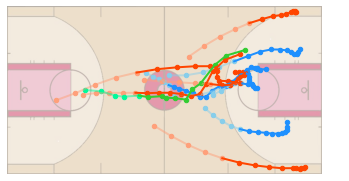

In [2]:
args = Arguments(model_names='10', past_length=5, future_length=10)

""" setup """
names = [x for x in args.model_names.split(',')]

torch.set_default_dtype(torch.float32)
device = torch.device('cuda', index=args.gpu) if args.gpu >= 0 and torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available(): torch.cuda.set_device(args.gpu)
torch.set_grad_enabled(False)

test_dset = NBADataset(
	obs_len=args.past_length,
	pred_len=args.future_length,
	training=False)

test_loader = DataLoader(
	test_dset,
	batch_size=128,
	shuffle=False,
	num_workers=4,
	collate_fn=seq_collate,
	pin_memory=True)

for name in names:
	np.random.seed(args.seed)
	random.seed(args.seed)
	torch.manual_seed(args.seed)
	torch.cuda.manual_seed_all(args.seed)

	""" model """
	saved_path = os.path.join(args.model_save_dir,str(name)+'.p')
	print('load model from:',saved_path)
	checkpoint = torch.load(saved_path, map_location='cpu')
	training_args = checkpoint['model_cfg']

	model = GroupNet(training_args,device)            
	model.set_device(device)
	model.eval()
	model.load_state_dict(checkpoint['model_dict'], strict=True)

	if args.vis:
		for data in test_loader:
			future_traj = np.array(data['future_traj']) * args.traj_scale # B,N,T,2
			past_traj = np.array(data['past_traj']) * args.traj_scale # B,N,T,2
			with torch.no_grad():
				prediction = model.inference(data)
			prediction = prediction * args.traj_scale
			prediction = np.array(prediction.cpu()) #(BN,20,T,2)
			batch = future_traj.shape[0]
			actor_num = future_traj.shape[1]

			y = np.reshape(future_traj,(batch*actor_num,args.future_length, 2))
			y = y[None].repeat(20,axis=0)
			error = np.mean(np.linalg.norm(y- prediction,axis=3),axis=2)
			indices = np.argmin(error, axis = 0)
			best_guess = prediction[indices,np.arange(batch*actor_num)]
			best_guess = np.reshape(best_guess, (batch,actor_num, args.future_length, 2))
			gt = np.reshape(future_traj,(batch,actor_num,args.future_length, 2))
			previous_3D = np.reshape(past_traj,(batch,actor_num,args.past_length, 2))

			draw_result(best_guess,previous_3D)
			draw_result(gt,previous_3D,mode='gt')
			break

	test_model_all(test_loader, args)

In [ ]:
len(test_loader)

In [ ]:
training_args.past_length, training_args.future_length

In [ ]:
test_dset.traj_abs.shape

In [ ]:
import numpy as np

In [ ]:
train = np.load('datasets/nba/train.npy')

In [ ]:
train[0]